In [0]:
# use NYT book list - find interest things about list
# Load in spark.read.json method - DRAG+DROP TO databricks FIRST!!
# BY THURSDAY MORNING
# IMPORTANT: SHOW YOU UNDERSTAND THE DATA -> this allows you to ask interesting questions from the data - analysis/nice display
# 'WHAT DOES YOUR RESULT MEAN'!!! VERY IMPORTANT!

In [0]:
# ALW analytics ideas
# average price per publisher, author
# bestseller count per author
# longest-lasting books
# most successful publishers

In [0]:
from datetime import datetime
import scipy.stats as sc_stats
import numpy as np
import matplotlib.pyplot as plt
nyt_file_data = spark.read.json('/FileStore/tables/nyt2.json').rdd
nyt_file_data

Out[2]: MapPartitionsRDD[17] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
nyt_file_data.count()

Out[108]: 10195

In [0]:
nyt_file_data.first()

Out[109]: Row(_id=Row($oid='5b4aa4ead3089013507db18b'), amazon_product_url='http://www.amazon.com/Odd-Hours-Dean-Koontz/dp/0553807056?tag=NYTBS-20', author='Dean R Koontz', bestsellers_date=Row($date=Row($numberLong='1211587200000')), description='Odd Thomas, who can communicate with the dead, confronts evil forces in a California coastal town.', price=Row($numberDouble=None, $numberInt='27'), published_date=Row($date=Row($numberLong='1212883200000')), publisher='Bantam', rank=Row($numberInt='1'), rank_last_week=Row($numberInt='0'), title='ODD HOURS', weeks_on_list=Row($numberInt='1'))

In [0]:
print(type(nyt_file_data.first().price),nyt_file_data.first().price[1])
print(nyt_file_data.first().price)
print(nyt_file_data.first().price['$numberDouble'])
print(nyt_file_data.first().price['$numberInt'])
nyt_file_data.filter(lambda x: x.rank['$numberInt']=='1').take(3)

<class 'pyspark.sql.types.Row'> 27
Row($numberDouble=None, $numberInt='27')
None
27
Out[4]: [Row(_id=Row($oid='5b4aa4ead3089013507db18b'), amazon_product_url='http://www.amazon.com/Odd-Hours-Dean-Koontz/dp/0553807056?tag=NYTBS-20', author='Dean R Koontz', bestsellers_date=Row($date=Row($numberLong='1211587200000')), description='Odd Thomas, who can communicate with the dead, confronts evil forces in a California coastal town.', price=Row($numberDouble=None, $numberInt='27'), published_date=Row($date=Row($numberLong='1212883200000')), publisher='Bantam', rank=Row($numberInt='1'), rank_last_week=Row($numberInt='0'), title='ODD HOURS', weeks_on_list=Row($numberInt='1')),
 Row(_id=Row($oid='5b4aa4ead3089013507db19f'), amazon_product_url='http://www.amazon.com/Blood-Anita-Blake-Vampire-Hunter/dp/0515146374?tag=NYTBS-20', author='Laurell K Hamilton', bestsellers_date=Row($date=Row($numberLong='1212192000000')), description='The vampire hunter Anita Blake is involved in a scandal that threatens the master vampire Jean-Claude’s power.', price=Row($numberDouble='25.95', $numberInt=None), published_date=Row($date=Row($numberLong='1213488000000')), publisher='Berkley', rank=Row($numberInt='1'), rank_last_week=Row($numberInt='0'), title='BLOOD NOIR', weeks_on_list=Row($numberInt='1')),
 Row(_id=Row($oid='5b4aa4ead3089013507db1b3'), amazon_product_url='http://www.amazon.com/Nothing-Lose-Jack-Reacher-No/dp/0440245583?tag=NYTBS-20', author='Lee Child', bestsellers_date=Row($date=Row($numberLong='1212796800000')), description='Jack Reacher exposes the secrets of a Colorado town.', price=Row($numberDouble=None, $numberInt='27'), published_date=Row($date=Row($numberLong='1214092800000')), publisher='Delacorte', rank=Row($numberInt='1'), rank_last_week=Row($numberInt='0'), title='NOTHING TO LOSE', weeks_on_list=Row($numberInt='1'))]

In [0]:
nyt_no_price = nyt_file_data.filter(
  lambda x: x.price[1] is None
)
print(nyt_no_price.count())
nyt_price_zero = nyt_file_data.filter(
  lambda x: x.price[0] is None
).filter(
  lambda x: float(x.price[1]) == 0.0
  #lambda x: x.price[0] is None# and float(x.price[0]) == 0.0
)
nyt_price_zero.count()

3033
Out[6]: 6184

In [0]:
# ALW DATA NOTES
# 10195 entries in total
# All entries haveeither a Double or Int price - 7162 have $numberDouble = None, 3033 have $numberInt = None -> NO ENTRIES have both!
# 6184 of the 7162 with (price($numberDouble) = None) have price($numberInt) = 0 !, none of the 3033 with (price($numberInt) = None) have this

In [0]:
def float_price_field(x):
  if x.price[1] is None:
    y = float(x.price[0])
  elif x.price[0] is None:
    y = float(x.price[1])
  return x.title,( x.author, x.publisher, x.rank[0], (datetime.utcfromtimestamp(int(x.bestsellers_date[0][0])/1000).strftime('%Y-%m-%d')),
                  (datetime.utcfromtimestamp(int(x.published_date[0][0])/1000).strftime('%Y-%m-%d')),y)


In [0]:
nyt_mainstays_maxrank = nyt_file_data.map(lambda x: (x.title, (x.author, int(x.rank[0]), int(x.weeks_on_list[0])))).reduceByKey(lambda x,y: (x[0],max(x[1],y[1]),max(x[2],y[2])))
nyt_mainstays_minrank = nyt_file_data.map(lambda x: (x.title, (x.author, int(x.rank[0]), int(x.weeks_on_list[0])))).reduceByKey(lambda x,y: (x[0],min(x[1],y[1]),max(x[2],y[2])))
nyt_mainstays_minrank.sortBy(lambda x: x[-1], False).take(3)
nyt_mainstays_maxrank.sortBy(lambda x: x[-1], False).take(3)

Out[38]: [('STAR WARS: FROM A CERTAIN POINT OF VIEW', ('various authors', 12, 1)),
 ('DANGEROUS WOMEN', ('edited George R R Martin and Gardner Dozois', 18, 0)),
 ('ROGUES', ('edited George R R Martin and Gardner Dozois', 7, 1))]

In [0]:
nyt_float_prices = nyt_file_data.map(float_price_field).filter(lambda x: x[1][-1] != 0.0).reduceByKey(lambda x,y: max(x,y)).mapValues(list).sortBy(lambda x: len(x[0]), False)
#print()
nyt_float_prices.take(5)


Out[9]: [('THE GUERNSEY LITERARY AND POTATO PEEL PIE SOCIETY',
 ['Mary Ann Shaffer and Annie Barrows',
 'Dial',
 '9',
 '2009-04-18',
 '2009-05-03',
 22.0]),
 ('BEARERS OF THE BLACK STAFF (LEGENDS OF SHANNARA)',
 ['Terry Brooks',
 'Del Rey/Ballantine',
 '5',
 '2010-08-29',
 '2010-09-12',
 27.0]),
 ('THE LOST FLEET. BEYOND THE FRONTIER: DREADNAUGHT',
 ['Jack Campbell', 'Ace', '15', '2011-04-30', '2011-05-15', 25.95]),
 ('THE LIMPOPO ACADEMY OF PRIVATE DETECTION',
 ['Alexander McCall Smith',
 'Pantheon',
 '9',
 '2012-04-14',
 '2012-04-29',
 24.95]),
 ('HOTEL ON THE CORNER OF BITTER AND SWEET',
 ['Jamie Ford', 'Ballantine', '16', '2009-03-28', '2009-04-12', 24.0])]

In [0]:
# count how many books hav multiple authors, and then percentage
nyt_author_rdd = nyt_file_data.map(float_price_field).reduceByKey(lambda x,y: max(x,y)).mapValues(list).sortBy(lambda x: len(x[0]), False)
print(nyt_author_rdd.filter(lambda x: (' and ' in x[1][0].lower() or ' & ' in x[1][0].lower() or 'various' in x[1][0].lower() )).count(),nyt_author_rdd.count())
print(round((nyt_author_rdd.filter(lambda x: (' and ' in x[1][0].lower() or ' & ' in x[1][0].lower() or 'various ' in x[1][0].lower() )).count()/nyt_author_rdd.count())*100,2),'% of titles have multiple authors')

197 2300
8.57 % of titles have multiple authors

In [0]:
def float_price_field2(x):
  if x.price[1] is None:
    y = float(x.price[0])
  elif x.price[0] is None:
    y = float(x.price[1])
  return x.title,( x.author, x.publisher, int(x.rank[0]), (int(x.published_date[0][0])/100), (int(x.bestsellers_date[0][0])/1000), y, 1)
#(datetime.utcfromtimestamp(int(x.bestsellers_date[0][0])/1000).strftime('%Y-%m-%d'))
              
nyt_author_ranks = nyt_file_data.map(float_price_field2).reduceByKey(lambda x,y: (x[0], x[1], x[2]+y[2], min(x[3],y[3]), max(x[3],y[3]),min(x[4],y[4]), max(x[4],y[4]), x[-2]+y[-2], x[-1]+y[-1]))
nyt_author_nums_dates = nyt_author_ranks.map(lambda x: (x[1][0],(x[1][2],x[1][7],x[1][8],x[1][3],x[1][4],x[1][5],x[1][6])))
#.reduceByKey(lambda x,y:(x[0]+y[0], x[1]+y[1], x[2]+y[2], min(x[3],y[3]), max(x[4],y[4]), min(x[5],y[5]), max(x[6],y[6])))
# author(rank, price, count, earliest published_date, latest published_date, earliest bestsellers_date,latest bestsellers_date)
#print(nyt_author_ranks.count())
nyt_author_nums_dates.count()

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2680010710939198> in <module> 
 12 # author(rank, price, count, earliest published_date, latest published_date, earliest bestsellers_date,latest bestsellers_date) 
 13 #print(nyt_author_ranks.count()) 
 ---> 14 nyt_author_nums_dates . count ( ) 

 /databricks/spark/python/pyspark/rdd.py in count (self) 
 1268 3 
 1269 """
 -> 1270 return self . mapPartitions ( lambda i : [ sum ( 1 for _ in i ) ] ) . sum ( ) 
 1271 
 1272 def stats ( self ) : 

 /databricks/spark/python/pyspark/rdd.py in sum (self) 
 1257 6.0 
 1258 """
 -> 1259 return self . mapPartitions ( lambda x : [ sum ( x ) ] ) . fold ( 0 , operator . add ) 
 1260 
 1261 def count ( self ) : 

 /databricks/spark/python/pyspark/rdd.py in fold (self, zeroValue, op) 
 1111 # zeroValue provided to each partition is unique from the one provided 
 1112 # to the final reduce call 
 -> 1113 vals = self . mapPartitions ( func ) . collect ( ) 
 1114 return reduce ( op , vals , zeroValue ) 
 1115 

 /databricks/spark/python/pyspark/rdd.py in collect (self) 
 965 # Default path used in OSS Spark / for non-credential passthrough clusters: 
 966 with SCCallSiteSync ( self . context ) as css : 
 --> 967 sock_info = self . ctx . _jvm . PythonRDD . collectAndServe ( self . _jrdd . rdd ( ) ) 
 968 return list ( _load_from_socket ( sock_info , self . _jrdd_deserializer ) ) 
 969 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 108 def deco ( * a , ** kw ) : 
 109 try : 
 --> 110 return f ( * a , ** kw ) 
 111 except py4j . protocol . Py4JJavaError as e : 
 112 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 56.0 failed 1 times, most recent failure: Lost task 0.0 in stage 56.0 (TID 69) (ip-10-172-198-103.us-west-2.compute.internal executor driver): org.apache.spark.api.python.PythonException: 'IndexError: tuple index out of range', from <command-2680010710939198>, line 10. Full traceback below:
Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/worker.py", line 713, in main
 process()
 File "/databricks/spark/python/pyspark/worker.py", line 703, in process
 out_iter = func(split_index, iterator)
 File "/databricks/spark/python/pyspark/rdd.py", line 2953, in pipeline_func
 return func(split, prev_func(split, iterator))
 File "/databricks/spark/python/pyspark/rdd.py", line 2953, in pipeline_func
 return func(split, prev_func(split, iterator))
 File "/databricks/spark/python/pyspark/rdd.py", line 2953, in pipeline_func
 return func(split, prev_func(split, iterator))
 File "/databricks/spark/python/pyspark/rdd.py", line 419, in func
 return f(iterator)
 File "/databricks/spark/python/pyspark/rdd.py", line 1270, in <lambda>
 return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
 File "/databricks/spark/python/pyspark/rdd.py", line 1270, in <genexpr>
 return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
 File "/databricks/spark/python/pyspark/util.py", line 73, in wrapper
 return f(*args, **kwargs)
 File "<command-2680010710939198>", line 10, in <lambda>
IndexE

In [0]:
bardata = nyt_author_rdd.map(lambda x: (x[1][1],(x[1][-1],1))).reduceByKey(lambda x,y:(x[0] + y[0], x[1] + y[1])).sortBy(lambda x: x[1][1], False)#.collect()
bardata_pn0 = nyt_float_prices.map(lambda x: (x[1][1],(x[1][-1],1))).reduceByKey(lambda x,y:(x[0] + y[0], x[1] + y[1])).mapValues(lambda x: (round((x[0]/float(x[1])),2),x[1]))
#print(type(bardata))
#print(bardata.map(lambda x: x[1]).collect()[0:2])
#bardata.take(10)
#print(bardata[0])
# nyt_float_prices nyt_author_rdd
#bardata.take(5)
#print(sum(bardata.map(lambda x: x[1][1]).collect()))
# take(20) collect()
print(bardata_pn0.take(5))
print(bardata_pn0.count(),bardata.count())

[('Dial', (24.8, 5)), ('Ace', (26.35, 15)), ('Ballantine', (26.26, 50)), ('Knopf', (25.81, 38)), ("Thomas Dunne/St. Martin's", (26.24, 4))]
112 166

In [0]:
#print(nyt_mainstays.first())
title_rank_weeks_rddmax = nyt_mainstays_maxrank.map(lambda x: (x[0],float(x[1][1]),float(x[1][2])))
title_rank_weeks_rddmin = nyt_mainstays_minrank.map(lambda x: (x[0],float(x[1][1]),float(x[1][2])))
title_rank_weeks_rddmax.first()

Out[39]: ('ODD HOURS', 20.0, 6.0)

Rank-Weeks Pearson correlation coefficient (worst ranks): 0.10798057110150416
Pearson 2-tailed p-value: 2.092409168853757e-07
Rank-Weeks Pearson correlation coefficient (best ranks): -0.3930508133007186
Pearson 2-tailed p-value: 2.092409168853757e-07

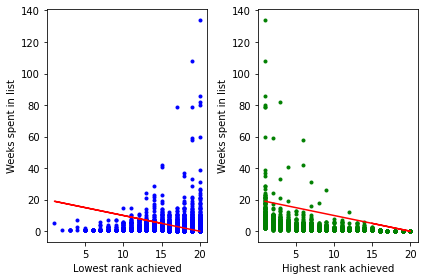

In [0]:
xmax = title_rank_weeks_rddmax.map(lambda x: x[1]).collect()
minus_xmax = title_rank_weeks_rddmax.map(lambda x: -x[1] + 20.0).collect()
xmin = title_rank_weeks_rddmin.map(lambda x: x[1]).collect()
minus_xmin = title_rank_weeks_rddmin.map(lambda x: -x[1] + 20.0).collect()
y = title_rank_weeks_rddmax.map(lambda x: x[2]).collect()
y_mean = title_rank_weeks_rddmax.map(lambda x: x[2]).mean()

fig, ax = plt.subplots(nrows=1,ncols=2)
# note: x.rank[0], x.weeks_on_list[0] in that order -> x = rank, y = weeks_on_list
ax[0].scatter(xmax,y,color='blue',marker='.')
ax[0].plot(xmax,minus_xmax,'r')
ax[0].set_ylabel('Weeks spent in list')
ax[0].set_xlabel('Lowest rank achieved')

ax[1].scatter(xmin,y,color='green',marker='.')
ax[1].plot(xmin,minus_xmin,'r')
ax[1].set_ylabel('Weeks spent in list')
ax[1].set_xlabel('Highest rank achieved')
#ax.set_ylim(0,10)
#ax.invert_xaxis()
fig.tight_layout()
#print(len(x))

"""
The Sig(2-tailed) p-value tells you if your correlation was significant at a chosen alpha level. The p-value is the probability you would see a given r-value by chance alone. If your p-value is small, then the correlation is significant
Source: https://www.statisticshowto.com/sig2-tailed-interpreting-results/
"""

print('Rank-Weeks Pearson correlation coefficient (worst ranks): ',sc_stats.pearsonr(xmax,y)[0])
print('Pearson 2-tailed p-value: ',sc_stats.pearsonr(xmax,y)[1])

print('Rank-Weeks Pearson correlation coefficient (best ranks): ',sc_stats.pearsonr(xmin,y)[0])
print('Pearson 2-tailed p-value: ',sc_stats.pearsonr(xmax,y)[1])


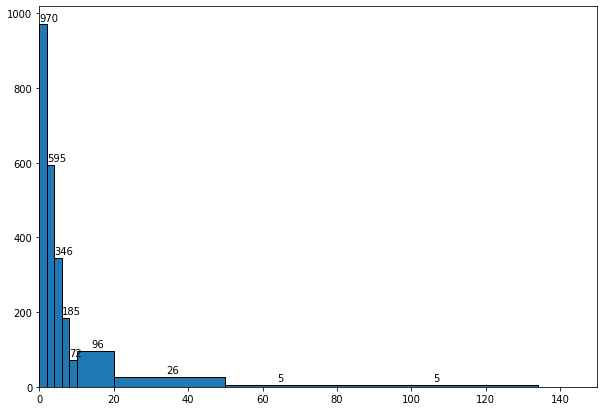

In [0]:
# bin number of weeks in list
fig, ax = plt.subplots(figsize=(10,7))
bin_list=[0, 2, 4, 6, 8, 10, 20, 50, 80, max(y)]
counts, bins, patches = ax.hist(y,bins=bin_list,edgecolor='black', linewidth=1.0)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
ax.set_xlim(0,150)
for count,bc in zip(counts,bin_centers):
  ax.annotate(str(int(count)), xy=(bc-1, count+10))

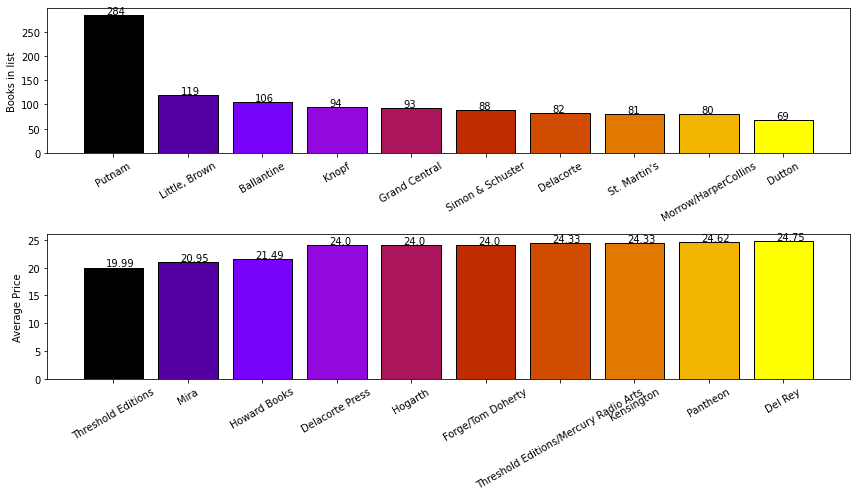

In [0]:
# bar plots: 1 = all entries, 2 = only those with non-zero prices
nbars = 10
bar_width = 0.8
publishers = bardata.map(lambda x: x[0])
book_count = bardata.map(lambda x: x[1][1])
publishers_price_order = bardata_pn0.sortBy(lambda x: x[1][0], True).map(lambda x: x[0])
price_average = bardata_pn0.sortBy(lambda x: x[1][0], True).map(lambda x: x[1][0])
#print(price_average.take(nbars))

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(1.5*nbars*bar_width,7))
col_map = plt.cm.gnuplot
for k in range(len(ax)):
  ax[k].set_prop_cycle('color',plt.cm.gnuplot(np.linspace(0, 1, nbars)))
  #ax[k].set_xlabel('Publisher')
  plt.setp(ax[k].get_xticklabels(), rotation=30, horizontalalignment='center')
for i in range(len(publishers.take(nbars))):
    ax[0].bar(publishers.take(nbars)[i], book_count.take(nbars)[i], width=bar_width, edgecolor='black', align='center')
ax[0].set_ylabel('Books in list')
for index, value in enumerate(book_count.take(nbars)):
    ax[0].text( x = (index - 0.1), y = (value + 2), s=str(value), color='black')
for j in range(len(publishers_price_order.take(nbars))):
    ax[1].bar(publishers_price_order.take(nbars)[j], price_average.take(nbars)[j], width=bar_width,edgecolor='black', align='center')
ax[1].set_ylabel('Average Price')
for index, value in enumerate(price_average.take(nbars)):
    ax[1].text( x = (index - 0.1), y = (value + 0.2), s=str(value), color='black')
fig.tight_layout()

Price-count correlation coefficient: -0.19184185617113111
Pearson 2-tailed p-value: 0.04272899776243417
[1, 15, 2, 2, 27]

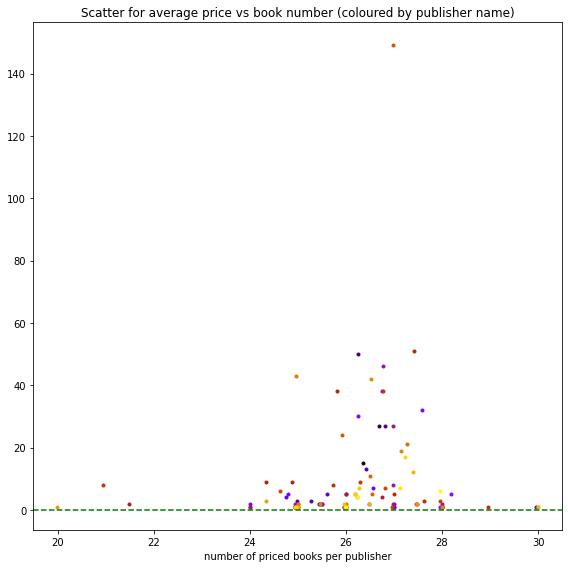

In [0]:
# average price vs number of books per publisher -> scatter plot
print('Price-count correlation coefficient: ',sc_stats.pearsonr(price_average.collect(), bardata_pn0.map(lambda x: x[1][1]).collect())[0])
print('Pearson 2-tailed p-value: ',sc_stats.pearsonr(price_average.collect(), bardata_pn0.map(lambda x: x[1][1]).collect())[1])

fig,ax = plt.subplots(figsize=(8,8))
ax.set_prop_cycle('color',plt.cm.gnuplot(np.linspace(0, 1, price_average.count())))
publishers_alpha_order = bardata_pn0.sortBy(lambda x: x[0], True).map(lambda x: x[0])
price_alpha_average = bardata_pn0.sortBy(lambda x: x[0], True).map(lambda x: x[1][0])
num_pub_alpha_priced_books = bardata_pn0.sortBy(lambda x: x[0], True).map(lambda x: x[1][1])
print(num_pub_alpha_priced_books.take(5))
for i in range(len(price_alpha_average.collect())):
    ax.scatter(price_alpha_average.collect()[i], num_pub_alpha_priced_books.collect()[i],marker='.')
#ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.axhline(0,color='g',linestyle='--')
ax.set_xlabel('average price per publisher')
ax.set_xlabel('number of priced books per publisher')
ax.set_title('Scatter for average price vs book number (coloured by publisher name)')
fig.tight_layout()

In [0]:
bardata_pn0.sortBy(lambda x: x[1][1], False).map(lambda x: (x[0],x[1][0],x[1][1])).collect()

Out[562]: [('Putnam', 26.98, 149),
 ('Little, Brown', 27.42, 51),
 ('Ballantine', 26.26, 50),
 ('Grand Central', 26.77, 46),
 ('Simon & Schuster', 24.96, 43),
 ('St. Martin’s', 26.52, 42),
 ('Knopf', 25.81, 38),
 ('Morrow/HarperCollins', 26.78, 38),
 ('Delacorte', 26.76, 38),
 ('Dutton', 27.58, 32),
 ('Doubleday', 26.26, 30),
 ('Atria', 26.69, 27),
 ('Harper/HarperCollins', 26.99, 27),
 ('Bantam', 26.81, 27),
 ('Random House', 25.92, 24),
 ('Scribner', 27.28, 21),
 ("St. Martin's", 27.15, 19),
 ('Viking', 27.24, 17),
 ('Ace', 26.35, 15),
 ('Berkley', 26.41, 13),
 ('Tor/Tom Doherty', 27.4, 12),
 ('Roc', 26.5, 11),
 ('Morrow', 26.29, 9),
 ('Hyperion', 24.87, 9),
 ('Kensington', 24.33, 9),
 ('Harper', 26.97, 8),
 ('Mira', 20.95, 8),
 ('Minotaur', 25.73, 8),
 ('William Morrow', 27.12, 7),
 ('Touchstone/Simon & Schuster', 26.28, 7),
 ('Del Rey/Ballantine', 26.57, 7),
 ('New American Library', 26.81, 7),
 ('Pantheon', 24.62, 6),
 ('Wizards of the Coast', 27.95, 6),
 ('Dial', 24.8, 5),
 ('LucasBooks', 27.0, 5),
 ('Baen', 26.0, 5),
 ('Tyndale House', 26.19, 5),
 ('Holt', 26.0, 5),
 ('Reagan Arthur/Little, Brown', 26.19, 5),
 ('Crown', 25.6, 5),
 ('Riverhead', 26.55, 5),
 ('Emily Bestler/Atria', 28.19, 5),
 ("Thomas Dunne/St. Martin's", 26.24, 4),
 ('Houghton Mifflin Harcourt', 26.75, 4),
 ('William Morrow/HarperCollins', 26.24, 4),
 ('Del Rey', 24.75, 4),
 ('Threshold Editions/Mercury Radio Arts', 24.33, 3),
 ('Center Street', 24.99, 3),
 ('Nan A. Talese/Doubleday', 27.95, 3),
 ('Berkley Sensation', 25.28, 3),
 ('Marian Wood/Putnam', 27.62, 3),
 ('Pocket Books', 25.0, 2),
 ("St. Martin''s", 25.47, 2),
 ('Spiegel & Grau', 25.0, 2),
 ('Thomas Dunne/St. Martin’s', 27.47, 2),
 ('Delacorte Press', 24.0, 2),
 ('Forge', 25.47, 2),
 ('Ecco/HarperCollins', 27.49, 2),
 ('Sarah Crichton/Farrar, Straus & Giroux', 26.0, 2),
 ('Gallery Books', 25.5, 2),
 ('Eos/HarperCollins', 26.49, 2),
 ('Tor/ Tom Doherty', 26.49, 2),
 ('Farrar, Straus & Giroux', 28.0, 2),
 ('Amy Einhorn/Putnam', 25.45, 2),
 ('Touchstone', 25.97, 2),
 ('Harper Voyager/HarperCollins', 26.99, 2),
 ('Atlantic Monthly', 25.5, 2),
 ('Penguin Press', 27.45, 2),
 ('Howard Books', 21.49, 2),
 ('HQN', 24.95, 2),
 ('Del Rey/Ballantine/Lucas', 27.0, 2),
 ('Voice', 25.99, 1),
 ('Ecco', 25.95, 1),
 ('Double\xadday', 24.95, 1),
 ('Eos/William Morrow', 25.99, 1),
 ("McSweeney's", 25.0, 1),
 ('DAW', 29.95, 1),
 ('Morrow/HarperCollins Publishers', 25.99, 1),
 ('Orbit', 25.99, 1),
 ('Twelve', 24.99, 1),
 ('Viking,', 24.95, 1),
 ('Shaye Areheart', 25.0, 1),
 ('Little, Brown & Company', 27.99, 1),
 ('Harper Voyager/HarperCollins Publishers', 24.99, 1),
 ('Silver Oak', 24.95, 1),
 ('Ballantine,', 26.0, 1),
 ('Doherty', 27.95, 1),
 ('Berkeley Prime Crime', 24.95, 1),
 ('Houghton Mifflin', 26.0, 1),
 ('FaithWords', 24.99, 1),
 ('HarperCollins Voyager', 27.99, 1),
 ('Del Rey/Ballantine/LucasBooks', 27.0, 1),
 ('Hogarth', 24.0, 1),
 ('Daw', 25.95, 1),
 ('Marion Wood/Putnam', 28.95, 1),
 ('Atria/Emily Bestler', 25.99, 1),
 ('Ecco/HarperCollins Publishers', 27.99, 1),
 ('Forge/Tom Doherty', 24.0, 1),
 ('allantine', 26.0, 1),
 ('Threshold Editions', 19.99, 1),
 ('Atria/Emily Bestler Books', 26.99, 1),
 ('Tor/TomDoherty', 29.99, 1),
 ('John Macrae/Holt', 28.0, 1),
 ('ACE', 24.95, 1),
 ('Tor', 29.99, 1),
 ('St.Martin’s', 27.99, 1),
 ('Del Rey/ Ballantine', 27.0, 1),
 ('Tom Doherty/Forge', 24.99, 1),
 ('Pocket Books/Karen Hunter', 25.99, 1),
 ('El León Literary Arts/Atlantic Monthly', 24.95, 1),
 ('Nan. A Talese/Doubleday', 26.95, 1)]

('ODD HOURS', ('Dean R Koontz', '8', '4'))
Out[314]: ('ODD HOURS', 8.0, 4.0)